# LSTM을 사용하여 훈련한 네트워크를 실험하기 위한 코드

In [1]:
#그냥 실행시키시면 자동으로 다운로드 됩니다.
import os
import tqdm
files = {"X_val_enc":"1IAvlfsYw13kC6jVUj6jOdqSAwBNQLS3G",
         "X_train_enc":"1rPCnDqif5epOr-F2ypwnoUX9k8TcO4Ia",
         "X_test_enc":"1ctp5kNmNzljgsi1W8X4W7gN3o7y6flUJ",
        "X_val":"1-7CBfLwKpPAqFqA1vq8EZJe1olGw3zsu",
         "X_train":"1-18adV66ZrHnpzsfer6MfS7HU71CT0Cf",
         "X_test":"1-9vV59f_kCgTuh-P-_Nq5uSHzshBCpvT",
         "y_train":"1LH2LoFZg8YgjBHCNvPEGD_ltROLohaYI",
         "y_test":"1-4nHZFlaHKshaa_CE6w36z4gL9bVrz6k",
         "y_val":"1-1N-5ilxadcYtWguUPAS21BbfzUiLgDl"}
print("Now starting To download!")
for name, idx in tqdm.tqdm_notebook(files.items()):
    os.system(f'wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id={idx}" -O- | sed -rn "s/.*confirm=([0-9A-Za-z_]+).*/\1\n/p")&id={idx}" -O {name}.npy && rm -rf /tmp/cookies.txt')

Now starting To download!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
import numpy as np

X_auto_val = np.load("X_val_enc.npy")
X_auto_test = np.load("X_test_enc.npy")
X_auto_train = np.load("X_train_enc.npy")

X_val = np.load("X_val.npy")
X_test = np.load("X_test.npy")
X_train = np.load("X_train.npy")

y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")
y_train = np.load("y_train.npy")

In [ ]:
from tensorflow.keras.layers import Dropout, Flatten, LSTM, Dense, Input
from keras.models import Sequential, Model

In [ ]:
xInput = Input(batch_shape=(None, 256, 1))
xLstm = LSTM(4)(xInput)
xLstm = Dropout(0.5)(xLstm)
xOutput = Dense(2, activation = "softmax")(xLstm)
model = Model(xInput, xOutput)
print(model.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dropout_11 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 10        
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from tensorflow.keras.utils import to_categorical

one_y_train = to_categorical(y_train)
one_y_test = to_categorical(y_test)
one_y_val = to_categorical(y_val)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history = model.fit(X_auto_train, one_y_train, epochs=2, validation_data = (X_auto_val, one_y_val), batch_size = 16)

Epoch 1/2
10/10 [==============================] - 1s 105ms/step - loss: 0.7133 - accuracy: 0.4444 - val_loss: 0.7020 - val_accuracy: 0.3704
Epoch 2/2
10/10 [==============================] - 1s 64ms/step - loss: 0.7068 - accuracy: 0.5229 - val_loss: 0.6934 - val_accuracy: 0.5185


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.argmax(model.predict([X_auto_test]), axis = 1)))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.33      0.33      0.33         6

    accuracy                           0.60        20
   macro avg       0.52      0.52      0.52        20
weighted avg       0.60      0.60      0.60        20



In [ ]:
model.save("/content/bestLSTM.h5")

In [ ]:
import tensorflow as tf

LSTM = tf.keras.models.load_model("/content/bestLSTM.h5")

In [ ]:
print(classification_report(y_test, np.argmax(LSTM.predict([X_auto_test]), axis = 1)))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.33      0.33      0.33         6

    accuracy                           0.60        20
   macro avg       0.52      0.52      0.52        20
weighted avg       0.60      0.60      0.60        20



In [ ]:
## Evaluation Function

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def evaluation(y_true, y_pred, model_name = "Temp Name"): 
    print(classification_report(y_true, y_pred))

    plt.figure(figsize=[8,8])
    plt.title(model_name+" confusion matrix", fontsize = 20)
    labels = ["Negative", "Positive"]
    conf_m = pd.DataFrame(confusion_matrix(y_true, y_pred), index = labels, columns = labels)
    ax = sns.heatmap(conf_m, cmap="Blues", annot=True,fmt='5')
    plt.yticks(va="center")
    plt.savefig("/content/"+model_name+"_confusion_matrix.pdf")
    plt.savefig("/content/"+model_name+"_confusion_matrix.jpg")

def AUROC_Curve(y_true, y_pred_softmax, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_softmax)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc="lower right")
    plt.savefig("/content/"+model_name+"_auroc_curve.pdf")
    plt.savefig("/content/"+model_name+"_auroc_curve.jpg")
    plt.show()

In [ ]:
y_pred_softmax = LSTM.predict([X_auto_test])
y_pred = np.argmax(y_pred_softmax,axis = 1)

# 인코딩된 데이터

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.33      0.33      0.33         6

    accuracy                           0.60        20
   macro avg       0.52      0.52      0.52        20
weighted avg       0.60      0.60      0.60        20



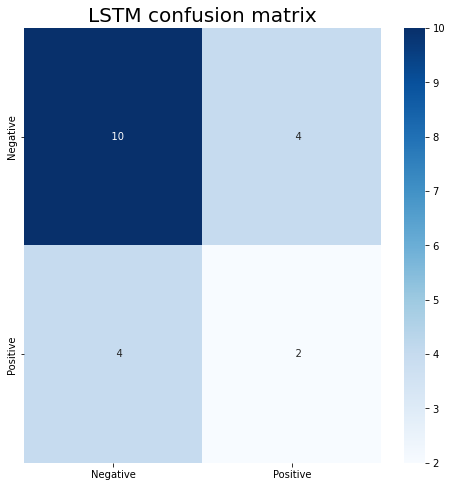

In [ ]:
evaluation(y_test , y_pred , "LSTM")

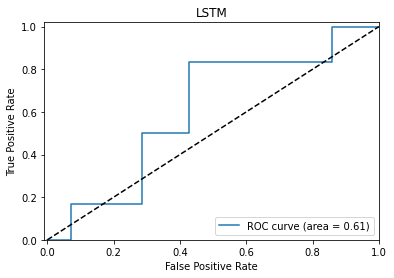

In [ ]:
# roc_curve(y_test, y_pred_softmax)
AUROC_Curve(y_test, y_pred_softmax[:,1], "LSTM")

# 인코딩 안한 원래의 데이터로 실험한 결과

In [ ]:
from tensorflow.keras.layers import Dropout, Flatten, LSTM, Dense, Input
from keras.models import Sequential, Model
xInput = Input((12, 5000))
# xLstm = Flatten()(xInput)
xLstm = Dense(16, activation = "relu")(xInput)
xLstm = LSTM(10)(xLstm)
xLstm = Dropout(0.5)(xLstm)
xOutput = Dense(2, activation = "softmax")(xLstm)
model = Model(xInput, xOutput)
print(model.summary())

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 12, 5000)]        0         
_________________________________________________________________
dense_46 (Dense)             (None, 12, 16)            80016     
_________________________________________________________________
lstm_17 (LSTM)               (None, 10)                1080      
_________________________________________________________________
dropout_21 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 22        
Total params: 81,118
Trainable params: 81,118
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 5)
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/bestFULL_LSTM.h5', save_best_only=True, monitor='val_accuracy', mode='max')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history = model.fit(X_train.reshape(153, 12, 5000), one_y_train, epochs=100,callbacks=[mcp_save], validation_data = (X_val.reshape(27, 12, 5000), one_y_val), batch_size = 16)

Epoch 1/100
10/10 [==============================] - 1s 57ms/step - loss: 0.8132 - accuracy: 0.5490 - val_loss: 0.6016 - val_accuracy: 0.6667
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7559 - accuracy: 0.6536 - val_loss: 0.6048 - val_accuracy: 0.6667
Epoch 3/100
10/10 [==============================] - 0s 16ms/step - loss: 0.7342 - accuracy: 0.5621 - val_loss: 0.5349 - val_accuracy: 0.7407
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7193 - accuracy: 0.6144 - val_loss: 0.5902 - val_accuracy: 0.7037
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6909 - accuracy: 0.6209 - val_loss: 0.5476 - val_accuracy: 0.7778
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6596 - accuracy: 0.6601 - val_loss: 0.5584 - val_accuracy: 0.7037
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6422 - accuracy: 0.6993 - val_loss: 0.5759 - val_accuracy: 0.7778
Epoch 

In [ ]:
import tensorflow as tf
FULL_LSTM = tf.keras.models.load_model("/content/bestFULL_LSTM.h5")
print(classification_report(y_test, np.argmax(FULL_LSTM.predict([X_test.reshape(20, 12, 5000)]), axis = 1)))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.17      0.17      0.17         6

    accuracy                           0.50        20
   macro avg       0.40      0.40      0.40        20
weighted avg       0.50      0.50      0.50        20



In [ ]:
y_pred_softmax = FULL_LSTM.predict([X_test.reshape(20, 12, 5000)])
y_pred = np.argmax(y_pred_softmax, axis = 1)

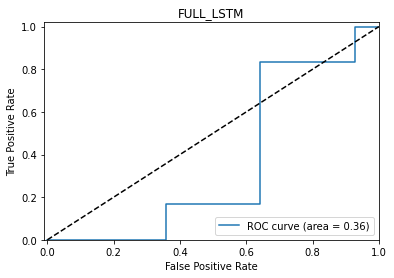

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.17      0.17      0.17         6

    accuracy                           0.50        20
   macro avg       0.40      0.40      0.40        20
weighted avg       0.50      0.50      0.50        20



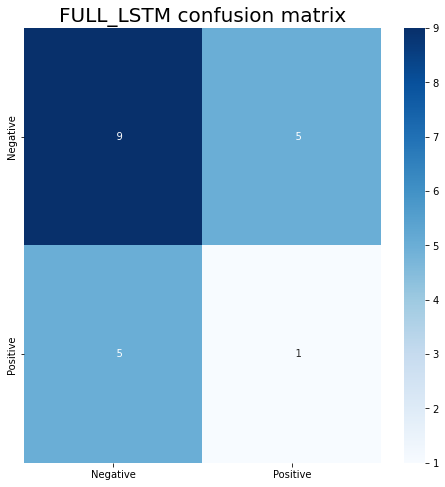

In [ ]:
# roc_curve(y_test, y_pred_softmax)
AUROC_Curve(y_test, y_pred_softmax[:,1], "FULL_LSTM")
evaluation(y_test, y_pred,"FULL_LSTM")